## Project: **Finding Lane Lines on the Road** 
***
In this project, you will identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
# pip install --user opencv-contrib-python

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
print("Python Notebook works correctly!")

Python Notebook works correctly!


## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


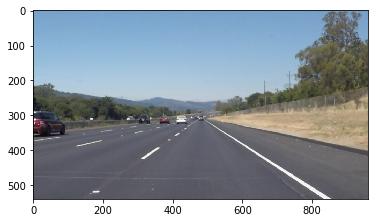

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [89]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    y,x,z = img.shape
    left_lines = np.array([])
    right_lines = np.array([])
    y_left_intercepts = np.array([])
    y_right_intercepts = np.array([])
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1);
            y_intercept = y1 - (slope*x1)
            if(math.isinf(slope) or math.isnan(x1) or math.isnan(x2) or math.isnan(y1) or math.isnan(y2)):
                continue
            if(slope > 0):
                right_lines = np.append(slope, right_lines)
                y_right_intercepts = np.append(y_intercept,y_right_intercepts)
            else:
                left_lines = np.append(slope, left_lines)
                y_left_intercepts = np.append(y_intercept,y_left_intercepts)
                
    left_mean = np.average(left_lines, axis=0)
    right_mean = np.average(right_lines, axis=0)
    y_left_intercept_mean = np.average(y_left_intercepts, axis=0)
    y_right_intercept_mean = np.average(y_right_intercepts, axis=0)
    
    y1 = int((y*0.6))
    y2 = y
    print((y1-y_left_intercept_mean)/left_mean, y1, y_left_intercept_mean, left_mean )
    x1_left = int((y1-y_left_intercept_mean)/left_mean)
    x2_left = int((y2-y_left_intercept_mean)/left_mean)
    
    
    x1_right = int((y1-y_right_intercept_mean)/right_mean)
    x2_right = int((y2-y_right_intercept_mean)/right_mean)
        
    cv2.line(img, (x1_left, y1), (x2_left, y2), color, thickness)
    cv2.line(img, (x1_right, y1), (x2_right, y2), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [34]:
import os
os.listdir("test_images/")

['solidYellowLeft.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowCurve.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [35]:
imageSolidYellowLeft = mpimg.imread('test_images/solidYellowLeft.jpg')
imageSolidYellowCurve = mpimg.imread('test_images/solidYellowCurve.jpg')
imageSolidWhiteRight = mpimg.imread('test_images/solidWhiteRight.jpg')
imageWhiteCarLaneSwitch = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
imageSolidYellowCurve2 = mpimg.imread('test_images/solidYellowCurve2.jpg')

In [161]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
def process_image(image):
    y = image.shape[0]
    x = image.shape[1]
    temp = image
    print(x, y)
    image = region_of_interest(image, 
                               np.array([[[(2*x/4)-50, (y/2)+50],  
                                          [(2*x/4)+50, (y/2)+50],
                                          [(8*x/9)+50, y],
                                          [x/9, y],
                                         ]], dtype=np.int32))
    image = grayscale(image)
    image = gaussian_blur(image, 5)
    image = canny(image, 220, 240)
    
    image = hough_lines(image, 5, 1, 50, 2, 500)
    
    image = weighted_img(image, temp)

    return image
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)


960 540
455.7726788186549 324 619.0441926315258 -0.6473494492830699
960 540
461.2741439269428 324 620.0206036662281 -0.6417454946555865
960 540
441.72729429950317 324 607.587881316886 -0.6419976419310998
960 540
478.3260308013433 324 632.8929520268849 -0.6457790965492599
960 540
461.2741439269428 324 620.0206036662281 -0.6417454946555865


(-0.5, 959.5, 539.5, -0.5)

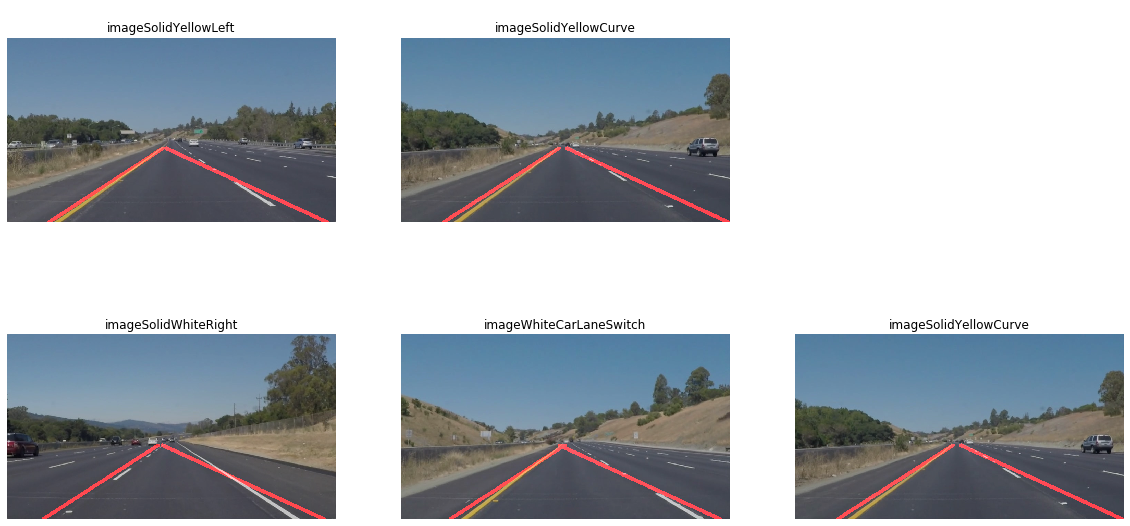

In [163]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches((20,10))
axs[0, 0].imshow(process_image(imageSolidYellowLeft), cmap='gray')
axs[0, 0].set_title("imageSolidYellowLeft")
axs[0, 0].axis('off')
axs[0, 1].imshow(process_image(imageSolidYellowCurve), cmap='gray')
axs[0, 1].set_title("imageSolidYellowCurve")
axs[0, 1].axis('off')
axs[0, 2].axis('off')
axs[1, 0].imshow(process_image(imageSolidWhiteRight), cmap='gray')
axs[1, 0].set_title("imageSolidWhiteRight")
axs[1, 0].axis('off')
axs[1, 1].imshow(process_image(imageWhiteCarLaneSwitch), cmap='gray')
axs[1, 1].set_title("imageWhiteCarLaneSwitch")
axs[1, 1].axis('off')
axs[1, 2].imshow(process_image(imageSolidYellowCurve), cmap='gray')
axs[1, 2].set_title("imageSolidYellowCurve")
axs[1, 2].axis('off')

## Test on Videos (Optional)


In [164]:
pip install moviepy

Note: you may need to restart the kernel to use updated packages.


In [165]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [166]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   4%|▍         | 9/221 [00:00<00:02, 83.08it/s, now=None]

960 540
458.4299944605418 324 620.6696109014571 -0.6471426706068033
Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4

960 540
458.4299944605418 324 620.6696109014571 -0.6471426706068033
960 540
463.3156879354094 324 623.2157753642272 -0.6458140381508961
960 540
459.3447735701634 324 620.2348910389633 -0.644907503217111
960 540
452.5307235535267 324 616.5374868979912 -0.6464477916567117
960 540
441.15999067896246 324 608.9319905233184 -0.6458699713108547
960 540
438.6208246056452 324 608.1469023000138 -0.6478189961807772
960 540
440.916724564293 324 609.3589077643023 -0.6471945650197087
960 540
438.73688510639613 324 607.81096622636 -0.6468819373541714
960 540
443.91513758011394 324 611.8940048279703 -0.6485338760857501
960 540
452.96815664915255 324 615.5570413517406 -0.6436590234257168
960 540
451.331357330604 324 613.9415927740731 -0.6424140225685415
960 540
458.5548787594628 324 618.723140499916 -0.642721

t:  11%|█         | 24/221 [00:00<00:02, 76.56it/s, now=None]

461.2304941008821 324 622.1599626658244 -0.6464446008650281
960 540
456.6207623231766 324 619.2400327873935 -0.6465760148208838
960 540
452.651928072725 324 615.3730022207203 -0.6437021122638564
960 540
441.3498327065897 324 608.1547687243861 -0.6438311463307902
960 540
438.61084594133206 324 608.5777120306154 -0.6488159484972702
960 540
439.0471329046157 324 607.945299828822 -0.646730791635781
960 540
444.7682341656274 324 611.1205018824049 -0.6455508281094644
960 540
444.56498706281195 324 610.6062847360786 -0.6446892874530049
960 540
451.5537769532019 324 614.8273530406453 -0.6440591749734962
960 540
446.1041697226531 324 611.7866410570834 -0.645110852104348
960 540
448.5280948599142 324 613.9553471349676 -0.6464597211586656
960 540
454.7952865569086 324 618.1395941201536 -0.6467516326894647
960 540
459.83586385440293 324 621.7957854961678 -0.6476132222484899
960 540
458.4838902776015 324 620.2435074336821 -0.6461372225190146
960 540
455.17799627712697 324 618.0520062733884 -0.64601

t:  19%|█▊        | 41/221 [00:00<00:02, 78.63it/s, now=None]

960 540
442.1905926773869 324 610.9133522731615 -0.6488454458878269
960 540
441.0087505338695 324 608.649265875848 -0.6454503805905477
960 540
440.65498876825234 324 608.5073552932349 -0.6456465092759043
960 540
440.35848034470354 324 608.7971213398057 -0.6467392682363523
960 540
441.39955181277065 324 610.1277517351177 -0.6482284600426715
960 540
444.4742677450034 324 616.6279448875413 -0.6583686978599694
960 540
448.6164025327232 324 613.7086018850332 -0.6457824552322318
960 540
452.68804903421193 324 616.229642942608 -0.6455430921272737
960 540
458.0765500052606 324 620.1535639743149 -0.6465154436980323
960 540
462.20435669215004 324 623.844884452457 -0.6487279492524729
960 540
460.94747731923974 324 621.848497647978 -0.6461658047901544
960 540
454.8314110931327 324 618.2220570125041 -0.646881569382767
960 540
443.38002222536403 324 611.051962160624 -0.647417447272172
960 540
440.30065898887017 324 608.7375581645721 -0.6466889211986613
960 540
438.0329364032778 324 607.6720363745542

t:  22%|██▏       | 48/221 [00:00<00:03, 52.52it/s, now=None]

446.1795289489115 324 611.0303426876247 -0.6433068396566672
960 540
442.80026105281814 324 610.7403630998894 -0.6475614138485938
960 540
442.3732917825043 324 610.1818762643147 -0.646923947671366
960 540
445.4757467582524 324 611.6808262115586 -0.6457833637521802
960 540


t:  24%|██▍       | 54/221 [00:00<00:03, 45.51it/s, now=None]

449.95221103385154 324 614.5610949407568 -0.6457599003083837
960 540
456.74741293199634 324 619.0834195552168 -0.6460538389500431
960 540
454.889489575892 324 618.4182671461841 -0.647230313939941
960 540
452.46888376394946 324 617.5819619579312 -0.6488445338289633
960 540
451.9726086679514 324 618.5093874585044 -0.6516089289713356
960 540
446.6620238356772 324 612.1711263992611 -0.645165944318733
960 540
438.94652870300246 324 607.7546137177102 -0.6464446012505151
960 540
441.55052864719624 324 609.7902049843157 -0.647242357199543


t:  27%|██▋       | 59/221 [00:01<00:04, 38.67it/s, now=None]

960 540
441.2724667761481 324 609.2521708420684 -0.6464309294574074
960 540
441.71703694255115 324 609.7110264229431 -0.6468191229402412
960 540
444.50578394263863 324 610.6934493151388 -0.6449712459807614
960 540
444.5213644885566 324 611.0895735264445 -0.6458397648822908
960 540
447.0622636864369 324 613.1380714012121 -0.6467512355370916
960 540
447.99537024408573 324 614.1170254572876 -0.6475893384773603
960 540
453.0669648472828 324 616.6582363680004 -0.6459491842815067
960 540


t:  31%|███       | 69/221 [00:01<00:04, 36.00it/s, now=None]

448.56762037779583 324 614.5660902147293 -0.6477642991039048
960 540
445.1514102587167 324 612.2362422875301 -0.6475015818101321
960 540
439.86093706491897 324 608.0867111619674 -0.6458557403565007
960 540
440.1914963366329 324 608.7642979233289 -0.6469100386836134
960 540
439.74891549340094 324 609.021835528979 -0.6481467616791794
960 540
438.24437850696546 324 607.9317567580579 -0.6478845381322902
960 540
440.1312747845659 324 607.7573853794108 -0.6447107979734081
960 540


t:  33%|███▎      | 74/221 [00:01<00:03, 38.70it/s, now=None]

438.1888961801774 324 607.9147197950653 -0.6479276911624966
960 540
441.6828996838334 324 610.6360329270557 -0.6489633923618873
960 540
441.3087078547435 324 609.5257251852224 -0.6469977140791046
960 540
444.050428224609 324 611.0835464905219 -0.6465111353193195
960 540
447.2953146516818 324 614.6541479495454 -0.6498036944023969
960 540
447.4354829116631 324 613.6054826439198 -0.6472564061288283
960 540
442.38444451201934 324 610.03547942505 -0.6465767116666294
960 540
442.5219706787006 324 608.6300749382881 -0.6431998720916567


t:  38%|███▊      | 84/221 [00:01<00:03, 36.67it/s, now=None]

960 540
438.9142154968339 324 608.0922643952724 -0.6472614792703649
960 540
436.3027781486899 324 605.5589813171657 -0.6453293341653024
960 540
439.30407881191394 324 607.8476257819839 -0.6461301851547615
960 540
440.7593565994969 324 608.5398122750263 -0.6455672648001843
960 540
441.06901663643214 324 608.2140891747997 -0.644375547714053
960 540
440.83682386089356 324 608.7108119872182 -0.6458417186969366
960 540
442.0206851412371 324 609.4483146653968 -0.6457804448092482


t:  40%|███▉      | 88/221 [00:01<00:04, 29.87it/s, now=None]

960 540
443.8613654438199 324 610.4745876059077 -0.6454145593849103
960 540
443.93692806647874 324 611.0698731356032 -0.646645626859442
960 540
447.8976090819166 324 612.5104611611258 -0.6441437848987485
960 540
445.4555509221461 324 611.1751894379468 -0.6446775415492295
960 540


t:  42%|████▏     | 92/221 [00:02<00:04, 26.60it/s, now=None]

440.9804182246057 324 610.7190728402858 -0.6501854980196657
960 540
435.37355335442953 324 605.9671384829327 -0.6476441582417122
960 540
438.46854147618444 324 607.839870698813 -0.6473437518304375
960 540
437.38781111314375 324 607.2690607877109 -0.6476382139383274
960 540
440.9922854958349 324 609.6020948880513 -0.6476351271472497
960 540
440.0508870301563 324 608.8024863929953 -0.6472035275626613
960 540
443.14475412022665 324 610.205306587796 -0.6458506028261537


t:  46%|████▌     | 101/221 [00:02<00:03, 30.92it/s, now=None]

960 540
439.8467554554507 324 609.1961164872674 -0.6483988183383409
960 540
445.0912579591048 324 611.4388252753349 -0.6457975081185372
960 540
445.6016455103015 324 611.5494189695031 -0.645306007881103
960 540
443.9535585795934 324 610.8310600157416 -0.6460834798428982
960 540
445.8501106353288 324 610.2947960348132 -0.6421323875569931
960 540
443.01779828319025 324 610.6446275950551 -0.6470273399982528
960 540
435.07465221174016 324 606.6552731921234 -0.6496707444463165
960 540


t:  49%|████▉     | 109/221 [00:02<00:03, 33.25it/s, now=None]

439.00333013351025 324 608.383936031985 -0.6477944847149514
960 540
441.29166970341186 324 610.141640537651 -0.6484184048386054
960 540
440.8080945852736 324 609.5188399456628 -0.647716871475076
960 540
440.181584008629 324 609.8383157355437 -0.6493645489038459
960 540
439.28585068923303 324 609.1818262887408 -0.6491941997250645
960 540
443.9143848793415 324 611.0662188662504 -0.64667023337006
960 540
449.80600552224325 324 614.9305213225645 -0.6467911004984964
960 540
445.35357171713434 324 612.9933419638826 -0.6489076552134093


t:  53%|█████▎    | 117/221 [00:02<00:03, 33.67it/s, now=None]

960 540
451.2157401857368 324 615.825033797462 -0.6467527787867865
960 540
447.05434612891673 324 613.6359534690636 -0.6478763845537953
960 540
443.8869211899502 324 611.409856775596 -0.6474843998672496
960 540
439.4273994253698 324 608.9396467458453 -0.6484339554576137
960 540
436.8902096909329 324 607.4731456975521 -0.6488429802491755
960 540
440.3962171553606 324 609.1451050964675 -0.6474740108766093
960 540
439.2693231999467 324 608.6484001085006 -0.64800427681797


t:  57%|█████▋    | 125/221 [00:03<00:02, 33.33it/s, now=None]

960 540
443.2017673630464 324 610.4802807599357 -0.6463879475581308
960 540
442.04182467549657 324 610.6105871141389 -0.6483788888631523
960 540
443.79981669496357 324 611.725295017834 -0.6483222484420176
960 540
450.04675147784815 324 615.253258940666 -0.6471622292223164
960 540
451.4326041685831 324 615.9872918574117 -0.646801514027046
960 540
453.22532505030034 324 617.9592280831678 -0.6485940035467861
960 540
449.7094594454178 324 615.4149375112445 -0.6480071330289955
960 540
445.1294240275638 324 612.4213416829516 -0.647949396544704


t:  60%|██████    | 133/221 [00:03<00:02, 35.15it/s, now=None]

960 540
437.1652142506683 324 609.3959329510253 -0.6528331249781936
960 540
441.1872604885562 324 610.027755201257 -0.6483137225778445
960 540
438.6225828435097 324 608.8950481322508 -0.6495220703989488
960 540
443.0727757959163 324 610.8544293984611 -0.6474205707700468
960 540
438.8037442510588 324 609.4462817183359 -0.6505101322814136
960 540
449.6974155907209 324 614.7416099091265 -0.6465271976873814
960 540
450.83784638818133 324 613.5555033939453 -0.642260861002853
960 540


t:  62%|██████▏   | 137/221 [00:03<00:02, 33.26it/s, now=None]

456.35982401421694 324 618.8870459792201 -0.6461722317826855
960 540
459.9442021528203 324 621.6189137613391 -0.6470761287310514
960 540
456.5222574669905 324 616.1349882246553 -0.639914009550298
960 540
456.1688154014786 324 617.3004001112852 -0.6429646004037971
960 540
457.4571229802328 324 618.1942796892978 -0.6431078781169405
960 540
441.2971479423668 324 608.1961549450732 -0.6440017939617164
960 540
445.2742114186315 324 611.9714721806869 -0.6467283862301785
960 540


t:  66%|██████▌   | 145/221 [00:03<00:02, 32.93it/s, now=None]

440.2169936022914 324 609.7870658999649 -0.6491958966903393
960 540
446.40242309941834 324 613.8427343529621 -0.649285755082945
960 540
450.0518591671698 324 615.2232673212528 -0.6470882441418361
960 540
448.5139327370373 324 615.2529519449228 -0.6493732539534813
960 540
456.8905185410739 324 619.022193061567 -0.6457174773589548
960 540
461.1365337978276 324 622.2520634752043 -0.6467760448708333
960 540
460.55538848075736 324 621.6666110921874 -0.6463209823124767


t:  70%|██████▉   | 154/221 [00:03<00:01, 34.76it/s, now=None]

960 540
464.73253695603887 324 624.4184921496204 -0.6464330948664314
960 540
458.2674052937749 324 620.7261932331477 -0.6474957411446919
960 540
452.6581164774819 324 617.4683620725434 -0.6483223240450664
960 540
440.7143104761409 324 609.4054984939781 -0.6475975290787143
960 540
443.42977947462816 324 612.2225657134418 -0.6499846854104508
960 540
441.94429773738256 324 611.9305742882681 -0.6515087438900855
960 540
441.79391770693303 324 611.0880653982241 -0.6498234898486446
960 540
446.7640268324243 324 613.5778809294678 -0.6481674072610258


t:  73%|███████▎  | 162/221 [00:04<00:01, 34.47it/s, now=None]

960 540
451.46462526569167 324 616.7609455611316 -0.6484692912292712
960 540
453.1373969400052 324 616.2843318116454 -0.6450236369485599
960 540
458.83394507999856 324 621.5604963623779 -0.6485145651342288
960 540
461.62484398527744 324 622.1136148774825 -0.6457919645394784
960 540
465.3709197072922 324 626.3818474308697 -0.6497652402111009
960 540
460.61000071883404 324 627.7973288280564 -0.6595543482641416
960 540
446.71957936686294 324 614.6552819414256 -0.6506437043869272


t:  75%|███████▌  | 166/221 [00:04<00:01, 34.04it/s, now=None]

960 540
439.19362341840383 324 610.2182152158422 -0.6516902795357128
960 540
439.7227044981376 324 609.0222758878045 -0.6481863978643198
960 540
438.6738305670302 324 608.3121692463236 -0.648117460936344
960 540
448.3566732664114 324 613.4613447821052 -0.6456050774783688
960 540
446.4154734761561 324 614.5232828028725 -0.6507912473118831
960 540
453.1051421975996 324 617.0228442758034 -0.6466994456399612
960 540
456.4615394218431 324 618.601444731902 -0.645402557036998


t:  79%|███████▉  | 175/221 [00:04<00:01, 36.33it/s, now=None]

960 540
469.2160884630705 324 627.3328640278747 -0.6464673132190532
960 540
469.95012037242896 324 627.4532424554382 -0.6457137242883472
960 540
479.68664338655753 324 633.8258820949911 -0.6458922431269711
960 540
474.8854596533446 324 631.550752229638 -0.6476314361238664
960 540
465.3296528562859 324 624.5155255170572 -0.6458121112042466
960 540
436.1562810158737 324 607.7455405827205 -0.6505593360293572
960 540
435.9971638073833 324 607.543286659059 -0.6503328695604177
960 540
445.3358886831217 324 612.8470199394832 -0.6486048559742553


t:  83%|████████▎ | 183/221 [00:04<00:01, 35.41it/s, now=None]

960 540
450.3372793284467 324 616.2446740263997 -0.6489462175154623
960 540
443.5408219096661 324 612.839031965642 -0.6512118337203887
960 540
452.80973780116227 324 618.1734766484989 -0.6496624345514325
960 540
460.8443373012038 324 622.8777266876667 -0.6485437760566924
960 540
465.6368676317886 324 625.5899983739207 -0.6476935555120366
960 540
478.78600203165655 324 633.6318451437825 -0.646701958348628
960 540
478.2034902933604 324 632.9566133297244 -0.6460777045775864
960 540


t:  86%|████████▋ | 191/221 [00:05<00:00, 33.87it/s, now=None]

471.13956677078005 324 629.4452235118415 -0.6483115515119694
960 540
462.62977720101213 324 622.9683318501411 -0.646236681216133
960 540
435.06681615054805 324 608.4040113008767 -0.6537019159890677
960 540
439.4867872119495 324 609.3865626277702 -0.6493632366930249
960 540
440.47236671451554 324 607.5479719655981 -0.6437361192044421
960 540
445.46342911705216 324 613.3517079424867 -0.6495521046834468
960 540
447.48401263578864 324 613.1322718894478 -0.6461287190717475


t:  88%|████████▊ | 195/221 [00:05<00:00, 33.29it/s, now=None]

960 540
452.200682650517 324 615.2641661275137 -0.6441037736172924
960 540
453.73868780708796 324 618.5920499468365 -0.6492548637864567
960 540
467.7310430361903 324 626.6121269437888 -0.6469789239975129
960 540
477.42101527017417 324 631.707730801957 -0.6445207080543452
960 540
476.7698238549126 324 630.8483383147296 -0.6435984891697082
960 540
472.7708603736054 324 627.7445287078658 -0.6424772636533327
960 540
456.96730485362855 324 617.0318958727058 -0.6412535268066214


t:  92%|█████████▏| 204/221 [00:05<00:00, 35.27it/s, now=None]

960 540
442.2783801296681 324 610.0905148385352 -0.6468562057106626
960 540
433.9727583828557 324 607.6089660460381 -0.6535179007614921
960 540
441.15527529248567 324 610.3433069301884 -0.6490760123866659
960 540
451.30967511880795 324 618.3040980806059 -0.6521112094553033
960 540
443.6745478869519 324 611.384339190584 -0.6477368164554019
960 540
453.5332401003372 324 618.6341378716936 -0.64964177224697
960 540
454.0298457742831 324 618.276094236206 -0.6481426209643996
960 540
460.5532591090852 324 622.5129662129314 -0.6481616627583706


t:  96%|█████████▌| 212/221 [00:05<00:00, 33.88it/s, now=None]

960 540
475.1348451283324 324 631.2860477508212 -0.6467343974063284
960 540
474.6427586340844 324 631.0385242311349 -0.6468834057738985
960 540
467.1680237377242 324 625.2703369762437 -0.6448864683970361
960 540
453.8287818086766 324 618.4390168206137 -0.6487887692956904
960 540
436.88636139837627 324 607.8702679670266 -0.6497576785377802
960 540
440.34915975014593 324 610.5275768627735 -0.6506826924010691
960 540
438.5889870497958 324 609.5209098898425 -0.6509988128302582


t:  98%|█████████▊| 216/221 [00:05<00:00, 28.09it/s, now=None]

960 540
442.2906650281077 324 610.5428114470378 -0.6478608618810165
960 540
449.8540711839837 324 614.0073555308396 -0.6446698476409495
960 540
457.46766020620163 324 618.600242592459 -0.6439804782258689
960 540
456.76407677940824 324 618.3523693590886 -0.6444297709104748
960 540
468.3052725974012 324 624.8858177159311 -0.6424993168389983
960 540
478.27672327231465 324 632.3786886596066 -0.6447704302850343
960 540


473.1447060836847 324 630.3121368519744 -0.647396310078966
960 540
478.93106082037144 324 633.1241040705247 -0.6454459302368473
960 540
460.41190494817374 324 622.1174248751083 -0.6475015560439644
Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 4.17 s, sys: 236 ms, total: 4.4 s
Wall time: 7.07 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [167]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))